We first test our fused_fftconv operator against the minimal fftconv implementation in pytorch.

In [13]:
import torch 
import fused_fftconv # while this is not used in the code, it is needed to load the fused_fftconv operator

import time
import matplotlib.pyplot as plt
from statistics import median
from memory_profiler import memory_usage

x = torch.randn(1, 100, 1024)
h = torch.randn(100, 1024)
y = torch.ops.fftconv.fused_fftconv(x, h)

In [14]:
def native_fftconv(x, h):
    # test against minimal fft conv in pytorch
    with torch.no_grad():
        N = x.shape[-1] + h.shape[-1]
        X = torch.fft.rfft(x, dim=-1, n=N)
        H = torch.fft.rfft(h, dim=-1, n=N)
        Y = X * H
        y = torch.fft.irfft(Y, dim=-1, n=N)
        y = y[..., :x.shape[-1]]
    return y

y_native = native_fftconv(x, h)
(y - y_native).abs().max()


tensor(0.)

In [15]:
def measure_peak_memory(func, *args, **kwargs):
    #baseline = min(memory_usage(-1, interval=0.001, timeout=1))
    mem_usage = memory_usage((func, args, kwargs), interval=0.001, timeout=None)
    return max(mem_usage)# - baseline

# Define a range of sequence lengths to test
sequence_lengths = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536]
channels = 128
iters = 20  # Number of iterations for median timing and memory profiling

methods = {
    "native_fftconv": native_fftconv,
    "fused_fftconv": torch.ops.fftconv.fused_fftconv,
}
stats = {name: {"times": [], "peak_memory": []} for name in methods}

for L in sequence_lengths:
    # Create random inputs of length L for each channel
    x = torch.randn(1, channels, L)
    h = torch.randn(channels, L)

    # Warm-up runs for each method for reliable measurements
    for name, func in methods.items():
        _ = func(x, h)
    
    # Measure timing and peak memory for each method
    for name, func in methods.items():
        run_times = []
        mem_peaks = []
        for _ in range(iters):
            start = time.perf_counter()
            _ = func(x, h)
            run_times.append((time.perf_counter() - start) * 1000)
        # for _ in range(iters):
        peak_mem = measure_peak_memory(func, x, h)
        mem_peaks.append(peak_mem)
        stats[name]["times"].append(median(run_times))
        stats[name]["peak_memory"].append(median(mem_peaks))
    
    # Print the results for the current sequence length
    times_str = ", ".join(f"{name}: {stats[name]['times'][-1]:.2f} ms" for name in methods)
    mem_str = ", ".join(f"{name}: {stats[name]['peak_memory'][-1]:.2f} MB" for name in methods)
    print(f"L={L}, {times_str}, {mem_str}")

L=2, native_fftconv: 0.02 ms, fused_fftconv: 0.02 ms, native_fftconv: 639.64 MB, fused_fftconv: 639.64 MB
L=4, native_fftconv: 0.03 ms, fused_fftconv: 0.03 ms, native_fftconv: 639.64 MB, fused_fftconv: 639.64 MB
L=8, native_fftconv: 0.08 ms, fused_fftconv: 0.06 ms, native_fftconv: 639.64 MB, fused_fftconv: 639.64 MB
L=16, native_fftconv: 0.08 ms, fused_fftconv: 0.03 ms, native_fftconv: 639.64 MB, fused_fftconv: 639.64 MB
L=32, native_fftconv: 0.04 ms, fused_fftconv: 0.04 ms, native_fftconv: 639.64 MB, fused_fftconv: 639.64 MB
L=64, native_fftconv: 0.05 ms, fused_fftconv: 0.04 ms, native_fftconv: 639.64 MB, fused_fftconv: 639.64 MB
L=128, native_fftconv: 0.07 ms, fused_fftconv: 0.11 ms, native_fftconv: 639.64 MB, fused_fftconv: 639.64 MB
L=256, native_fftconv: 0.17 ms, fused_fftconv: 0.16 ms, native_fftconv: 639.64 MB, fused_fftconv: 639.64 MB
L=512, native_fftconv: 0.25 ms, fused_fftconv: 0.19 ms, native_fftconv: 639.64 MB, fused_fftconv: 639.64 MB
L=1024, native_fftconv: 0.25 ms, fuse

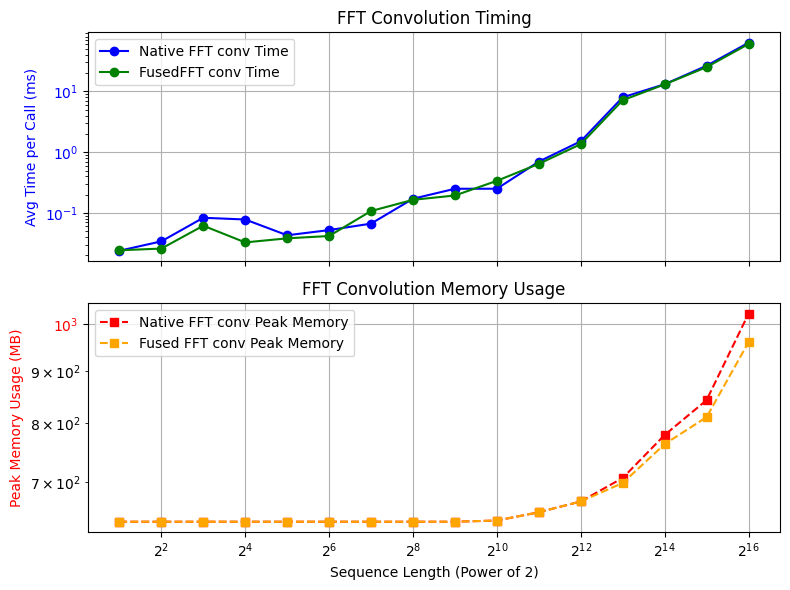

In [16]:
fig, (ax_time, ax_mem) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Plot timing results in the first subplot
ax_time.set_xscale('log', base=2)
ax_time.set_yscale('log')
lns1 = ax_time.plot(sequence_lengths, stats['native_fftconv']['times'], '-o', label='Native FFT conv Time', color='blue')
lns2 = ax_time.plot(sequence_lengths, stats['fused_fftconv']['times'], '-o', label='FusedFFT conv Time', color='green')
ax_time.set_ylabel('Avg Time per Call (ms)', color='blue')
ax_time.tick_params(axis='y', labelcolor='blue')
ax_time.grid(True)
ax_time.legend(loc='upper left')
ax_time.set_title('FFT Convolution Timing')

# Plot peak memory usage in the second subplot
ax_mem.set_xscale('log', base=2)
ax_mem.set_yscale('log')
lns3 = ax_mem.plot(sequence_lengths, stats['native_fftconv']['peak_memory'], '--s', label='Native FFT conv Peak Memory', color='red')
lns4 = ax_mem.plot(sequence_lengths, stats['fused_fftconv']['peak_memory'], '--s', label='Fused FFT conv Peak Memory', color='orange')
ax_mem.set_xlabel('Sequence Length (Power of 2)')
ax_mem.set_ylabel('Peak Memory Usage (MB)', color='red')
ax_mem.tick_params(axis='y', labelcolor='red')
ax_mem.grid(True)
ax_mem.legend(loc='upper left')
ax_mem.set_title('FFT Convolution Memory Usage')

plt.tight_layout()
plt.show()

In [17]:
import torch.nn as nn

class FFTConvModel(nn.Module):
    def __init__(self, channels: int, filter_length: int = 128):
        """
        channels: Number of input/output channels.
        seq_len: (Optional) Expected sequence length (not strictly required for the model definition).
        """
        super().__init__()
        self.linear = nn.Linear(channels, channels)
        self.filter = nn.Parameter(torch.randn(channels, filter_length))
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.transpose(1, 2)  # (N, L, C)
        x = self.linear(x)     # (N, L, C)
        x = x.transpose(1, 2)  # (N, C, L)
        x = torch.ops.fftconv.fused_fftconv(x, self.filter) # (N, C, L)
        return x

In [19]:
from torch.export import export, ExportedProgram
from executorch.backends.xnnpack.partition.xnnpack_partitioner import XnnpackPartitioner
from executorch.exir import EdgeProgramManager, ExecutorchProgramManager, to_edge_transform_and_lower
from executorch.exir.backend.backend_api import to_backend
from torch.export import export, ExportedProgram
from executorch.exir import EdgeProgramManager, to_edge
from executorch.exir.backend.backend_api import LoweredBackendModule, to_backend
from executorch.backends.xnnpack.utils.configs import get_xnnpack_edge_compile_config
from executorch.backends.xnnpack.partition.xnnpack_partitioner import XnnpackPartitioner
from executorch.exir.backend.test.backend_with_compiler_demo import (  # noqa
    BackendWithCompilerDemo,
)
from executorch.devtools import Inspector

SEQ_LEN = 256
CHANNELS = 4
model = FFTConvModel(channels=CHANNELS, filter_length=SEQ_LEN)
example_input = torch.randn(1, CHANNELS, SEQ_LEN)



exported_program: ExportedProgram = export(model, (example_input,))
edge_program: EdgeProgramManager = to_edge_transform_and_lower(exported_program, partitioner=[XnnpackPartitioner()])
# edge_program.save("fftconv.pte")
print(edge_program.exported_program().graph_module)

edge_manager_to_backend: LoweredBackendModule = edge_program.to_backend(XnnpackPartitioner())
et_program = edge_manager_to_backend.to_executorch()
print(et_program)

# # Serialize and save it to a file   
# save_path = "test.pte"
# with open(save_path, "wb") as f:
#     f.write(et_program.buffer)



GraphModule(
  (lowered_module_0): LoweredBackendModule()
)



def forward(self, p_filter, x):
    lowered_module_0 = self.lowered_module_0
    executorch_call_delegate = torch.ops.higher_order.executorch_call_delegate(lowered_module_0, x);  lowered_module_0 = x = None
    getitem = executorch_call_delegate[0];  executorch_call_delegate = None
    fftconv_fused_fftconv_default = executorch_exir_dialects_edge__ops_fftconv_fused_fftconv_default(getitem, p_filter);  getitem = p_filter = None
    return (fftconv_fused_fftconv_default,)
    
# To see more debug info, please use `graph_module.print_readable()`


RuntimeError: Missing out variants: {'fftconv::fused_fftconv'}

In [7]:
from executorch.devtools.backend_debug import get_delegation_info
from tabulate import tabulate
graph_module = edge_program.exported_program().graph_module
delegation_info = get_delegation_info(graph_module)
print(delegation_info.get_summary())
df = delegation_info.get_operator_delegation_dataframe()
print(tabulate(df, headers="keys", tablefmt="fancy_grid"))


Total delegated subgraphs: 1
Number of delegated nodes: 3
Number of non-delegated nodes: 2

╒════╤═══════════════════════════════╤═══════════════════════════════════╤═══════════════════════════════════════╕
│    │ op_type                       │   occurrences_in_delegated_graphs │   occurrences_in_non_delegated_graphs │
╞════╪═══════════════════════════════╪═══════════════════════════════════╪═══════════════════════════════════════╡
│  0 │ aten_linear_default           │                                 1 │                                     0 │
├────┼───────────────────────────────┼───────────────────────────────────┼───────────────────────────────────────┤
│  1 │ aten_permute_copy_default     │                                 2 │                                     0 │
├────┼───────────────────────────────┼───────────────────────────────────┼───────────────────────────────────────┤
│  2 │ fftconv_fused_fftconv_default │                                 0 │                             